In [1]:
!pip install textblob
!pip install vaderSentiment
import pandas as pd
import numpy as np
import re
from datetime import datetime
import itertools as IT


import plotly
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_post= pd.read_csv("/content/drive/MyDrive/asalytics/reddit_posts_table.csv")
df_comment= pd.read_csv("/content/drive/MyDrive/asalytics/reddit_comments_table.csv")

In [3]:
df_post.head()

,id,title,post_text,score,total_comments,post_url,time_created,asa_id
0,r2inwn,r/choicecoin Lounge,A place for members of r/choicecoin to chat wi...,86,120,https://www.reddit.com/r/choicecoin/comments/r...,1.637916e+09,choicecoin
1,sgxogi,To an Amazing community...🎁$choice,Choice referral program is to reward and encou...,7,5,https://www.reddit.com/r/choicecoin/comments/s...,1.643623e+09,choicecoin
2,ttvgjy,It has a pulse... Choice coin is on the up!,Looks like moves higher... seems like we have ...,15,4,https://www.reddit.com/r/choicecoin/comments/t...,1.648832e+09,choicecoin
3,tq90u4,Choicecoin Dead?,NaN,6,22,https://www.reddit.com/r/choicecoin/comments/t...,1.648473e+09,choicecoin
4,tq6115,New introduction,NaN,2,0,https://app.kaafila.org/#/watch?v=QmNQm7uFRUXn...,1.648462e+09,choicecoin


In [4]:
df_comment.head()

,id,body,score,parent_id,created_at,asa_id
0,hpedoe6,Anyone think it will go back up?😅,2,t3_r2inwn,1640071042.0,choicecoin
1,hrdqoi7,"Fair to say this is a rug pull coin, yeah?",2,t3_r2inwn,1641405064.0,choicecoin
2,hmpgv8u,Hi there,1,t3_r2inwn,1638304386.0,choicecoin
3,hmpgweu,any chart to follow choice coin?,1,t3_r2inwn,1638304399.0,choicecoin
4,hmq5qo3,Hi everyone,1,t3_r2inwn,1638314603.0,choicecoin


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj= SentimentIntensityAnalyzer()
from textblob import TextBlob

# Reddit Analysis

In [6]:
class reddit_analysis():
  def __init__(self):
    self.data= None


  def rename_post_columns(self, df_post):
    self.data= df_post
    self.data['post_body'] = self.data.title.astype(str).str.cat(self.data.post_text.astype(str), sep='-')
    self.data.drop(['title', 'post_text'], axis=1, inplace=True)
    self.data.rename(columns = {'id':'parent_id', "score": "post_upvotes",
                              "time_created": "post_time_created"}, inplace = True)
    return self.data


  def rename_comment_columns(self, df_comment):
    self.data= df_comment
    self.data.rename(columns= {"id": "comment_id", "body": "comment_body", "score": "comment_upvotes",
                                "created_at": "comment_time_created"}, inplace= True)
    return self.data


  def strip_commentid_prefix(self, df_comment):
    self.data= df_comment
    self.data['parent_id'] = df_comment['parent_id'].str.lstrip("t3_")
    return self.data

  
  def merge_two_dfs(self, df_post, df_comment):
    df = pd.merge(df_post, df_comment, on='parent_id', 
                   how='inner')
    return df


  def remove_URL(self, df, data:str):
    for i in df[data]:
        df[data].replace(i, re.sub(r"http\S+", "", i), inplace= True) 
    return df
    

  def special_character_removal(self, post_comment_text):
      data= post_comment_text.split(" ")
      data_list= []
      for i, word in enumerate(data):
        text= ""
        for char in word:
          if char.isalpha():
            text += char.lower()
        data_list.append(text)
      return " ".join(data_list)


  def access_scr(self, df, data:list):
    #df[data].apply(special_character_removal, axis= 1)
    for i in data:
      for j in df[i]:
        df[i].replace(j, reddit_analysis().special_character_removal(j), inplace= True)
    return df


  def unix_to_utc(self, df, date_columns:list):
    for i in date_columns:
      for j in df[i]:
        if str(j).startswith("202"):
          continue
        df[i].replace(j, datetime.utcfromtimestamp(float(j)).strftime('%Y-%m-%d'), inplace= True)
      df[i]= df[i].apply(pd.to_datetime)
    return df


  def extract_date(self, df,date_columns:list):
    for x in date_columns:
        df[x +'_year'] = df[x].dt.year
        df[x +'_day'] = df[x].dt.day
        df[x +'_month'] = df[x].dt.month
        df[x +'_weekday'] = df[x].dt.day_name()
    #df.drop(columns=date_columns,axis=1,inplace=True)
    return df


  def generate_sentiment(self, df):
    sentiment= {"post": [], "comment": []}
    post_score= [sid_obj.polarity_scores(i)["compound"] for i in df["post_body"]]
    comment_score= [sid_obj.polarity_scores(i)["compound"] for i in df["comment_body"]]
    for i, j in zip(post_score, comment_score):
      i = "negative" if i<0 else "positive" if i > 0 else "neutral"
      j = "negative" if j<0 else "positive" if j > 0 else "neutral"
      sentiment["post"].append(i)
      sentiment["comment"].append(j)
    df["post_sentiment"] = sentiment["post"]
    df["comment_sentiment"]= sentiment["comment"]
    return df


  def all(self, df_post, df_comment):
    df_post= reddit_analysis().rename_post_columns(df_post)
    df_comment= reddit_analysis().rename_comment_columns(df_comment)
    df_comment= reddit_analysis().strip_commentid_prefix(df_comment)
    df= reddit_analysis().merge_two_dfs(df_post, df_comment)
    df= reddit_analysis().remove_URL(df, "post_body")
    df= reddit_analysis().remove_URL(df, "comment_body")
    df= reddit_analysis().access_scr(df, ["post_body", "comment_body"])
    df = reddit_analysis().unix_to_utc(df, ['post_time_created', "comment_time_created"])
    df = reddit_analysis().extract_date(df, ['post_time_created', 'comment_time_created'])
    df= reddit_analysis().generate_sentiment(df)
    return df

In [7]:
clean_df= reddit_analysis().all(df_post, df_comment)

In [8]:
clean_df.head()

,parent_id,post_upvotes,total_comments,post_url,post_time_created,asa_id_x,post_body,comment_id,comment_body,comment_upvotes,...,post_time_created_year,post_time_created_day,post_time_created_month,post_time_created_weekday,comment_time_created_year,comment_time_created_day,comment_time_created_month,comment_time_created_weekday,post_sentiment,comment_sentiment
0,r2inwn,86,120,https://www.reddit.com/r/choicecoin/comments/r...,2021-11-26,choicecoin,rchoicecoin loungea place for members of rchoi...,hpedoe6,anyone think it will go back up,2,...,2021,26,11,Friday,2021,21,12,Tuesday,positive,neutral
1,r2inwn,86,120,https://www.reddit.com/r/choicecoin/comments/r...,2021-11-26,choicecoin,rchoicecoin loungea place for members of rchoi...,hrdqoi7,fair to say this is a rug pull coin yeah,2,...,2021,26,11,Friday,2022,5,1,Wednesday,positive,positive
2,r2inwn,86,120,https://www.reddit.com/r/choicecoin/comments/r...,2021-11-26,choicecoin,rchoicecoin loungea place for members of rchoi...,hmpgv8u,hi there,1,...,2021,26,11,Friday,2021,30,11,Tuesday,positive,neutral
3,r2inwn,86,120,https://www.reddit.com/r/choicecoin/comments/r...,2021-11-26,choicecoin,rchoicecoin loungea place for members of rchoi...,hmpgweu,any chart to follow choice coin,1,...,2021,26,11,Friday,2021,30,11,Tuesday,positive,neutral
4,r2inwn,86,120,https://www.reddit.com/r/choicecoin/comments/r...,2021-11-26,choicecoin,rchoicecoin loungea place for members of rchoi...,hmq5qo3,hi everyone,1,...,2021,26,11,Friday,2021,30,11,Tuesday,positive,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,nxagkm,12,11,https://www.reddit.com/r/Algogems/comments/nxa...,2021-06-11,Algogems,airdrop information eligible airdrop addresses...,h1ux5bf,can we get an updated list or is this complete,2,...,2021,11,6,Friday,2021,15,6,Tuesday,positive,neutral
4692,nx57l6,4,1,https://www.reddit.com/r/Algogems/comments/nx5...,2021-06-11,Algogems,image size limitationsok i had to resize my pi...,h1dnlxo,hi thank you for reporting the issue we were n...,1,...,2021,11,6,Friday,2021,11,6,Friday,neutral,positive
4693,nt82q1,7,2,https://i.redd.it/4bf1plom5j371.jpg,2021-06-05,Algogems,i was first one to hashtag algogems on instagr...,h0ql6yn,but you may want to setup a profile on instagram,2,...,2021,5,6,Saturday,2021,5,6,Saturday,neutral,positive
4694,nt3x6p,5,9,https://www.reddit.com/r/Algogems/comments/nt3...,2021-06-05,Algogems,error messagesplease someone who can explain ...,h0q3twt,regarding the issue of title description it ce...,2,...,2021,5,6,Saturday,2021,5,6,Saturday,negative,positive


In [9]:
clean_df.columns

Index(['parent_id', 'post_upvotes', 'total_comments', 'post_url',
       'post_time_created', 'asa_id_x', 'post_body', 'comment_id',
       'comment_body', 'comment_upvotes', 'comment_time_created', 'asa_id_y',
       'post_time_created_year', 'post_time_created_day',
       'post_time_created_month', 'post_time_created_weekday',
       'comment_time_created_year', 'comment_time_created_day',
       'comment_time_created_month', 'comment_time_created_weekday',
       'post_sentiment', 'comment_sentiment'],
      dtype='object')

# Reddit Visualizations

In [10]:
class reddit_visualization():
  def __init__(self):
    self.data= None

  def most_upvoted_asa_with_date(self, df):
    self.data= df
    trace= go.Bar(x= self.data.asa_id_x,
                   y= self.data.post_upvotes,
                   marker= dict(color='rgb(0,0,0)',
                                line= dict(color= '#6FD791', width= 3.0)),
                   text= self.data.post_time_created
               )
    data= [trace]
    layout= go.Layout(barmode= 'stack', title= "Most Upvoted ASA with Date")
    fig= go.Figure(data= data, layout= layout)
    return iplot(fig)


  def comment_time_plot(self, df):
    self.data= df[df.asa_id_x == 'choicecoin']
    trace= go.Bar(x= self.data.post_time_created_weekday,
                   y= df.total_comments,
                   marker= dict(color='rgb(0,0,0)',
                                line= dict(color= '#6FD791', width= 3.0)),
               text= self.data.asa_id_x
               )
    data= [trace]
    layout= go.Layout(barmode= 'relative')
    fig= go.Figure(data= data, layout= layout)
    fig.update_layout(xaxis_range=['2021-12-01','2022-03-31'],
                      title_text="Comments Are Mostly Dropped On")
    return iplot(fig)


  def comment_upvotes_plot(self, df):
    self.data= df[df.asa_id_x == 'choicecoin']
    trace= go.Scatter(x= self.data.comment_time_created,
                            y= self.data.comment_upvotes,
                            mode= 'lines+markers',
                            marker= dict(color= '#6FD791'),
                            text= self.data.asa_id_x
                            )
    data= [trace]
    layout= dict(title = 'Trend of Comment Upvotes with Time per ASA', 
                 xaxis= dict(title='Date', ticklen= 5, zeroline= False))

    fig= go.Figure(data= data, layout= layout)
    fig.update_layout(xaxis_range=['2022-01-01','2022-03-31'])

    return iplot(fig)


  def post_upvotes_plot(self, df):
    self.data= df[df.asa_id_x == 'choicecoin']
    trace= go.Scatter(x= self.data.post_time_created,
                        y= self.data.post_upvotes,
                        mode= 'lines+markers',
                        marker= dict(color= '#6FD791'),
                        text= self.data.asa_id_x
                        )
    data= [trace]
    layout= dict(title = 'Trend of Post Upvotes with Time per ASA', 
                xaxis= dict(title='Date', ticklen= 5, zeroline= False))
    fig= go.Figure(data= data, layout= layout)
    fig.update_layout(xaxis_range= None)

    return iplot(fig)

  def post_wordcloud(self, df):
    self.data= df
    stopwords = set(STOPWORDS)
    stopwords.update(["r", "lets", "going", "strong", "us", "keep", "will", "able", "us", "see", "one", "make", "borrow", "chat", "now"])
    plt.subplots(figsize=(10,10))
    cloud= WordCloud(background_color='white', width= 700, height= 700).generate(" ".join(self.data['post_body']))

    plt.imshow(cloud)
    plt.axis('off')
    plt.savefig('post.png')
    return plt.show()


  def comment_wordcloud(self, df):
    self.data= df
    plt.subplots(figsize=(10,10))
    cloud= WordCloud(background_color='white', width= 800, height= 800).generate(" ".join(self.data['comment_body']))

    plt.imshow(cloud)
    plt.axis('off')
    plt.savefig('comment.png')
    return plt.show()


  def post_sentiment(self, df):
    self.data= df[df.asa_id_x == 'choicecoin']
    fig = px.histogram(self.data, x='post_sentiment', barmode= "group", color= "post_sentiment", title= "Post Sentiment Analysis")
    return iplot(fig)


  def comment_sentiment(self, df):
    self.data= df[df.asa_id_x == 'choicecoin']
    fig = px.histogram(self.data, x='comment_sentiment', barmode= "group", color= "comment_sentiment", title= "Comment Sentiment Analysis")
    return iplot(fig)



In [11]:
reddit_visualization().most_upvoted_asa_with_date(clean_df)

In [12]:
reddit_visualization().comment_time_plot(clean_df)

In [13]:
reddit_visualization().post_upvotes_plot(clean_df)

In [14]:
reddit_visualization().comment_upvotes_plot(clean_df)

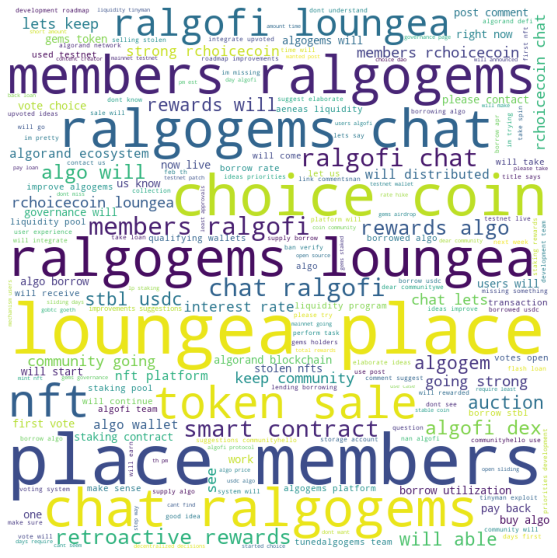

In [15]:
reddit_visualization().post_wordcloud(clean_df)

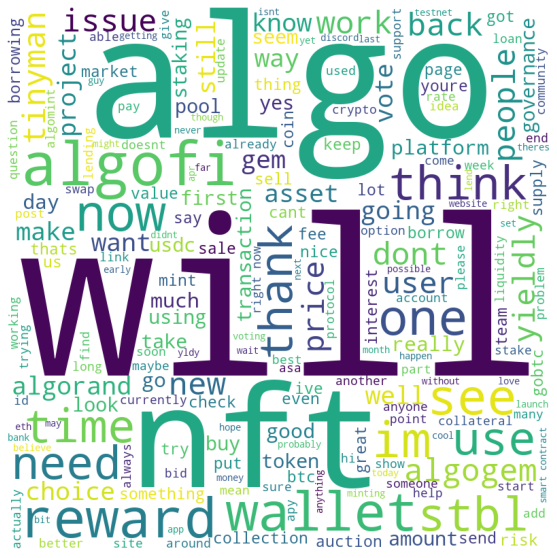

In [16]:
reddit_visualization().comment_wordcloud(clean_df)

In [17]:
reddit_visualization().post_sentiment(clean_df)

In [18]:
reddit_visualization().comment_sentiment(clean_df)